In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
% matplotlib inline

from asterixdb.asterixdb import AsterixConnection
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


Connect to Asterix and get ratings data

In [2]:
con = AsterixConnection(server='http://localhost', port=19002)

In [3]:
rated = con.query('''
    USE FactMap;
    
    SELECT r.*
    FROM reviews r
    WHERE r.reviewRating.bestRating >= r.reviewRating.ratingValue
    AND r.reviewRating.ratingValue >= r.reviewRating.worstRating
    AND r.reviewRating.bestRating > r.reviewRating.worstRating;
''').results

len(rated)

25477

In [4]:
unrated = con.query('''
    USE FactMap;
    
    SELECT r.*
    FROM reviews r
    WHERE NOT (r.reviewRating.bestRating >= r.reviewRating.ratingValue
    AND r.reviewRating.ratingValue >= r.reviewRating.worstRating
    AND r.reviewRating.bestRating > r.reviewRating.worstRating)
    OR is_null(r.reviewRating.ratingValue)
    OR is_null(r.reviewRating.worstRating)
    OR is_null(r.reviewRating.bestRating);
''').results

len(unrated)

34597

In [5]:
def getTitle(r):
    """Returns claim title in English if available, otherwise in original language."""
    if r['claimReviewed_en'] is not None:
        return r['claimReviewed_en']
    else:
        return r['claimReviewed']

In [6]:
# separate contractions with space (without removing ')
all_ratings = [r['reviewRating']['alternateName'].replace("'", " '") for r in rated + unrated]
all_claims = [getTitle(r).replace("'", " '") for r in rated + unrated]

t = Tokenizer(split=' ', filters='!"#$%&()*+,.-/:;<=>?@[\\]^_`´{|}~\t\n‘“”"’')
t.fit_on_texts(all_ratings + all_claims)

vocab_size = len(t.word_index) + 1  # add 1 for 0 mask
max_desc_length = max([len(x) for x in all_ratings])
max_claim_length = max([len(x) for x in all_claims])

In [7]:
vocab_size

37095

In [8]:
# token <-> word conversion
word2token = {w: tk for w, tk in t.word_index.items()}
token2word = dict(map(reversed, t.word_index.items()))

with open('../data/word2token.pickle', 'wb') as f:
    pickle.dump(word2token, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/token2word.pickle', 'wb') as f:
    pickle.dump(token2word, f, pickle.HIGHEST_PROTOCOL)

Create embedding matrix

In [9]:
def word2Vec(word):
    try:
        vec = con.query('''USE FactMap;
            SELECT vector
            FROM fasttext f
            WHERE f.word = "{0}"
            ;'''.format(word)).results[0]['vector']
        return vec
    except:
        return None

In [10]:
embedding_dim = 300
embedding_matrix_inv = np.zeros((vocab_size, embedding_dim))
embedding_matrix_oov = np.zeros((vocab_size, embedding_dim))
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in t.word_index.items():
    vec = word2Vec(word)
    if vec is not None:
        embedding_matrix_inv[idx] = vec
        embedding_matrix[idx] = vec
    else:
        random_vec = list(np.random.uniform(low=-1.0, high=1.0, size=300))
        embedding_matrix_oov[idx] = random_vec
        embedding_matrix[idx] = random_vec

In [11]:
count_inv = np.sum(np.sum(embedding_matrix_inv, axis=1) != 0)
count_oov = np.sum(np.sum(embedding_matrix_oov, axis=1) != 0)

print("Words in vocabulary:", count_inv)
print("Words out of vocabulary:", count_oov)
print("Total words:", embedding_matrix_inv.shape[0]-1)

Words in vocabulary: 29322
Words out of vocabulary: 7772
Total words: 37094


In [12]:
oov_words = [token2word[i] for i in np.nonzero(np.sum(embedding_matrix_oov, axis=1))[0]]
with open('../data/oov_words.txt', 'w') as f:
    f.write("oov words: {}\n".format(count_oov))
    f.write("inv words: {}\n".format(count_inv))
    f.write("total words: {}\n\n".format(count_inv + count_oov))
    for word in oov_words:
        f.write("%s\n" % word)

In [13]:
# with open('../data/embedding_matrix_inv.pickle', 'wb') as f:
#     pickle.dump(embedding_matrix_inv, f, pickle.HIGHEST_PROTOCOL)

# with open('../data/embedding_matrix_oov.pickle', 'wb') as f:
#     pickle.dump(embedding_matrix_oov, f, pickle.HIGHEST_PROTOCOL)
    
# with open('../data/embedding_matrix.pickle', 'wb') as f:
#     pickle.dump(embedding_matrix, f, pickle.HIGHEST_PROTOCOL)

Create dicts for both rated and unrated data

In [14]:
rated_desc_tokenized = t.texts_to_sequences([r['reviewRating']['alternateName'] for r in rated])
unrated_desc_tokenized = t.texts_to_sequences([r['reviewRating']['alternateName'] for r in unrated])

rated_claims_tokenized = t.texts_to_sequences([getTitle(r) for r in rated])
unrated_claims_tokenized = t.texts_to_sequences([getTitle(r) for r in unrated])

In [15]:
def isFake(r):
    """Returns True if rating is at most 50%, False otherwise."""
    bestDiff = r['reviewRating']['bestRating'] - r['reviewRating']['ratingValue']
    worstDiff = r['reviewRating']['ratingValue'] - r['reviewRating']['worstRating']
    return bestDiff >= worstDiff

unrated_ids = [r['uid'] for r in unrated]
rated_ids = [r['uid'] for r in rated]
rated_isFake = [isFake(r) for r in rated]

In [16]:
def isOov(token, embedding_matrix_inv):
    """Returns True if token is out of vocabulary, False otherwise."""
    return np.sum(embedding_matrix_inv[token,:]) == 0

In [17]:
rated_data = dict()
for r in zip(rated_ids, rated_desc_tokenized, rated_claims_tokenized, rated_isFake):
    ID = r[0]
    
    desc = np.array(r[1])
    
    desc_inv = np.array([x if not isOov(x, embedding_matrix_inv) else 0 for x in r[1]]) # in vocab
    desc_inv = desc_inv[np.nonzero(desc_inv)]
    desc_inv = np.array([0]) if desc_inv.size == 0 else desc_inv
    
    desc_oov = np.array([x if isOov(x, embedding_matrix_inv) else 0 for x in r[1]])  # out of vocab
    desc_oov = desc_oov[np.nonzero(desc_oov)]
    desc_oov = np.array([0]) if desc_oov.size == 0 else desc_oov
    
    claim = np.array(r[2])
    
    claim_inv = np.array([x if not isOov(x, embedding_matrix_inv) else 0 for x in r[2]]) # in vocab
    claim_inv = claim_inv[np.nonzero(claim_inv)]
    claim_inv = np.array([0]) if claim_inv.size == 0 else claim_inv
    
    claim_oov = np.array([x if isOov(x, embedding_matrix_inv) else 0 for x in r[2]])  # out of vocab
    claim_oov = claim_oov[np.nonzero(claim_oov)]
    claim_oov = np.array([0]) if claim_oov.size == 0 else claim_oov
    
    isFake = r[3]
    rated_data[ID] = {'rating': desc, 
                      'rating_inv': desc_inv,
                      'rating_oov': desc_oov,
                      'claim': claim,
                      'claim_inv': claim_inv,
                      'claim_oov': claim_oov,
                      'isFake': isFake}

In [18]:
unrated_data = dict()
for r in zip(unrated_ids, unrated_desc_tokenized, unrated_claims_tokenized):
    ID = r[0]
    
    desc = np.array(r[1])
    
    desc_inv = np.array([x if not isOov(x, embedding_matrix_inv) else 0 for x in r[1]])
    desc_inv = desc_oov[np.nonzero(desc_oov)]
    desc_inv = np.array([0]) if desc_inv.size == 0 else desc_inv
    
    desc_oov = np.array([x if isOov(x, embedding_matrix_inv) else 0 for x in r[1]])
    desc_oov = desc_oov[np.nonzero(desc_oov)]
    desc_oov = np.array([0]) if desc_oov.size == 0 else desc_oov
    
    claim = np.array(r[2])
    
    claim_inv = np.array([x if not isOov(x, embedding_matrix_inv) else 0 for x in r[2]])
    claim_inv = claim_inv[np.nonzero(claim_inv)]
    claim_inv = np.array([0]) if claim_inv.size == 0 else claim_inv
    
    claim_oov = np.array([x if isOov(x, embedding_matrix_inv) else 0 for x in r[2]])
    claim_oov = claim_oov[np.nonzero(claim_oov)]
    claim_oov = np.array([0]) if claim_oov.size == 0 else claim_oov
    
    unrated_data[ID] = {'rating': desc, 
                        'rating_inv': desc_inv,
                        'rating_oov': desc_oov,
                        'claim': claim,
                        'claim_inv': claim_inv,
                        'claim_oov': claim_oov}

In [19]:
with open('../data/data_rated.pickle', 'wb') as f:
    pickle.dump(rated_data, f, pickle.HIGHEST_PROTOCOL)

with open('../data/data_unrated.pickle', 'wb') as f:
    pickle.dump(unrated_data, f, pickle.HIGHEST_PROTOCOL)

In [20]:
with open('../data/data_rated.pickle', 'rb') as f:
    rated_data = pickle.load(f)

with open('../data/data_unrated.pickle', 'rb') as f:
    unrated_data = pickle.load(f)

Shuffle IDs and split into train/val

In [21]:
ids = list(rated_data.keys())
ids_pred = list(unrated_data.keys())
np.random.seed(2)
np.random.shuffle(ids)

trainFrac = 0.7
validFrac = 0.2

partition = dict()
partition["train"] = {ID: rated_data[ID] for ID in ids[:int(len(ids)*trainFrac)]}
partition["valid"] = {ID: rated_data[ID] for ID in ids[int(len(ids)*trainFrac):int(len(ids)*(trainFrac + validFrac))]}
partition["test"] = {ID: rated_data[ID] for ID in ids[int(len(ids)*(trainFrac + validFrac)):]}
partition["predict"] = {ID: unrated_data[ID] for ID in ids_pred}

In [22]:
with open('../data/partition.pickle', 'wb') as f:
    pickle.dump(partition, f, pickle.HIGHEST_PROTOCOL)

----

### RNN

In [23]:
with open('../data/partition.pickle', 'rb') as f:
    partition = pickle.load(f)

In [24]:
with open('../data/embedding_matrix.pickle', 'rb') as f:
    embedding_matrix = pickle.load(f)

with open('../data/embedding_matrix_oov.pickle', 'rb') as f:
    embedding_matrix_oov = pickle.load(f)
    
with open('../data/embedding_matrix_inv.pickle', 'rb') as f:
    embedding_matrix_inv = pickle.load(f)

In [25]:
with open('../data/word2token.pickle', 'rb') as f:
    word2token = pickle.load(f)
    
with open('../data/token2word.pickle', 'rb') as f:
    token2word = pickle.load(f)

Build RNN + insert pretrained embeddings

In [27]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM
from keras.layers.wrappers import Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam, SGD

rnn_in = Input(shape=(None,), name='rnn_in')
rnn = Embedding(input_dim=embedding_matrix.shape[0], 
                output_dim=embedding_matrix.shape[1], 
                input_length=None,
                weights=[embedding_matrix],
                embeddings_initializer=Constant(embedding_matrix),
                trainable=False,
                mask_zero=True,
                name="embedding")(rnn_in)

rnn = Bidirectional(LSTM(256, return_sequences=True, name="lstm_1"), name="bi_lstm_1")(rnn)
rnn = Bidirectional(LSTM(64, return_sequences=True, name="lstm_2"), name="bi_lstm_2")(rnn)
rnn_out = LSTM(1, activation='sigmoid', return_sequences=False, name="lstm_out")(rnn)

rnn_single = Model(inputs=rnn_in,
            outputs=rnn_out)
rnn_single.compile(loss='binary_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])

In [30]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(rnn_single, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [28]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.layers.merge import Add, Maximum, Concatenate
from keras.layers.wrappers import Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

rnn_in0 = Input(shape=(None,), name='rnn_in_inv')
rnn0 = Embedding(input_dim=embedding_matrix_inv.shape[0], 
                output_dim=embedding_matrix_inv.shape[1], 
                input_length=None,
                weights=[embedding_matrix_inv],
                embeddings_initializer=Constant(embedding_matrix_inv),
                trainable=False,
                mask_zero=True,
                name="embedding0")(rnn_in0)

rnn_in1 = Input(shape=(None,), name='rnn_in_oov')
rnn1 = Embedding(input_dim=embedding_matrix_oov.shape[0], 
                output_dim=embedding_matrix_oov.shape[1], 
                input_length=None,
                weights=[embedding_matrix_oov],
                embeddings_initializer=Constant(embedding_matrix_oov),
                trainable=True,
                mask_zero=True,
                name="embedding1")(rnn_in1)

rnn = Add(name="add")([rnn0, rnn1])
rnn = Bidirectional(LSTM(256, return_sequences=True, name="lstm_1"), name="bi_lstm_1")(rnn)
rnn = Bidirectional(LSTM(64, return_sequences=True, name="lstm_2"), name="bi_lstm_2")(rnn)
rnn_out = LSTM(1, activation='sigmoid', return_sequences=False, name="lstm_out")(rnn)

rnn_dual = Model(inputs=[rnn_in0, rnn_in1],
            outputs=rnn_out)
rnn_dual.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [29]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(rnn_dual, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

Define data generator

In [30]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, partition, mode="train", single=True, trainOov=False, batch_size=16):
        """Initialization"""
        assert type(trainOov) == bool
        assert type(single) == bool
        assert mode in partition.keys()
        assert batch_size > 0
        
        self.partition = partition
        self.mode = mode
        self.single = single
        self.oov = trainOov
        self.batch_size = batch_size
        self.IDs = list(partition[mode].keys())
        self.shuffle = True if mode == "train" else False
        self.idx = 0
        self.on_epoch_end() # set self.ID_queue on init


    def __len__(self):
        """Get number of batches per epoch"""
        batches_per_epoch = int(len(self.IDs) // self.batch_size)
        return batches_per_epoch

    def __getitem__(self, idx):
        """Get batch of IDs"""
        batch_IDs = self.ID_queue[idx*self.batch_size : (idx+1)*self.batch_size]
        X, y = self.__load_batch(batch_IDs)
        return X, y

    def on_epoch_end(self):
        """Update ID queue on epoch end"""
        self.ID_queue = []

        if self.shuffle:
            np.random.shuffle(self.IDs)

        # prepare sequence with every ID occurring exactly once
        self.ID_queue += self.IDs
        
    def __get_batch_length(self, batch_IDs):
        """Get max sentence length in batch"""
        if self.single and not self.oov:
            max_length = max([len(self.partition[self.mode][ID]['rating']) 
                              for ID in batch_IDs])
        elif not self.single and not self.oov:
            max_length = max([len(self.partition[self.mode][ID]['rating']) +
                              len(self.partition[self.mode][ID]['claim'])
                              for ID in batch_IDs])
        elif self.single and self.oov:
            max_inv = max([len(self.partition[self.mode][ID]['rating_inv']) 
                              for ID in batch_IDs])
            max_oov = max([len(self.partition[self.mode][ID]['rating_oov']) 
                              for ID in batch_IDs])
            max_length = max(max_inv, max_oov)
        elif not self.single and self.oov:
            # rating length
            max_rating_inv = max([len(self.partition[self.mode][ID]['rating_inv']) 
                                  for ID in batch_IDs])
            max_rating_oov = max([len(self.partition[self.mode][ID]['rating_oov']) 
                                  for ID in batch_IDs])
            max_rating = max(max_rating_inv, max_rating_oov)
            
            # claim length
            max_claim_inv = max([len(self.partition[self.mode][ID]['claim_inv']) 
                                 for ID in batch_IDs])
            max_claim_oov = max([len(self.partition[self.mode][ID]['claim_oov']) 
                                 for ID in batch_IDs])
            max_claim = max(max_claim_inv, max_rating_oov)
            
            # max length
            max_length = max_rating + max_claim
            
        return max_length

    def __load_batch(self, batch_IDs):
        """Load batch data"""
        # get batch max sentence length
        max_length = self.__get_batch_length(batch_IDs)
        
        # generate batch
        if self.mode != "predict":
            y = np.zeros(shape=(self.batch_size, 1), dtype=int)
            
        if self.oov:
            X_inv = np.zeros(shape=(self.batch_size, max_length), dtype=int)
            X_oov = np.zeros(shape=(self.batch_size, max_length), dtype=int)
            
        else:
            X = np.zeros(shape=(self.batch_size, max_length), dtype=int)

        # fill batch w/ data
        for i, ID in enumerate(batch_IDs):
            if self.single and not self.oov:
                rating = self.partition[self.mode][ID]['rating']
                X[i,:len(rating)] = rating
            elif not self.single and not self.oov:
                rating = self.partition[self.mode][ID]['rating']
                claim = self.partition[self.mode][ID]['claim']
                seq = np.concatenate([rating, claim])
                X[i,:len(seq)] = seq
            elif self.single and self.oov:
                rating_inv = self.partition[self.mode][ID]['rating_inv']
                rating_oov = self.partition[self.mode][ID]['rating_oov']
                X_inv[i,:len(rating_inv)] = rating_inv
                X_oov[i,:len(rating_oov)] = rating_oov
                X = [X_inv, X_oov]
            elif not self.single and self.oov:
                rating_inv = self.partition[self.mode][ID]['rating_inv']
                rating_oov = self.partition[self.mode][ID]['rating_oov']
                claim_inv = self.partition[self.mode][ID]['claim_inv']
                claim_oov = self.partition[self.mode][ID]['claim_oov']
                seq_inv = np.concatenate([rating_inv, claim_inv]) if rating_inv.sum() != 0 else np.concatenate([claim_inv, rating_inv])
                seq_oov = np.concatenate([rating_oov, claim_oov]) if rating_oov.sum() != 0 else np.concatenate([claim_oov, rating_oov])
                X_inv[i,:len(seq_inv)] = seq_inv
                X_oov[i,:len(seq_oov)] = seq_oov
                X = [X_inv, X_oov]
                
            if self.mode != "predict":
                tgt = self.partition[self.mode][ID]['isFake']
                y[i,:] = tgt
        
        batch = X, y if self.mode != "predict" else X
        return batch

Create train and validation data generators

In [31]:
gen_train = DataGenerator(partition, mode='train', single=True, trainOov=False, batch_size=2)
gen_valid = DataGenerator(partition, mode='valid', single=True, trainOov=False, batch_size=2)

Example deployment (real deployment performed on Titan X GPU in Copenhagen)

In [32]:
n_epochs = 20

out1 = rnn_single.fit_generator(generator=gen_train,
                         validation_data=gen_valid,
                         epochs=n_epochs,
                         workers=4,
                         use_multiprocessing=True,
                         verbose=1)

---

# Visualizing deployed models

Models were all deployed on Titan X GPU's in Copenhagen using `main.py` and the auxillary scripts under `/scripts/`. 

Below are the summary training results from these sessions:

SGD

In [36]:
r_sgd_t = pd.read_csv('./run_r_sgd_logs_training-tag-acc.csv')
r_sgd_v = pd.read_csv('./run_r_sgd_logs_validation-tag-acc.csv')

rc_sgd_t = pd.read_csv('./run_rc_sgd_logs_training-tag-acc.csv')
rc_sgd_v = pd.read_csv('./run_rc_sgd_logs_validation-tag-acc.csv')

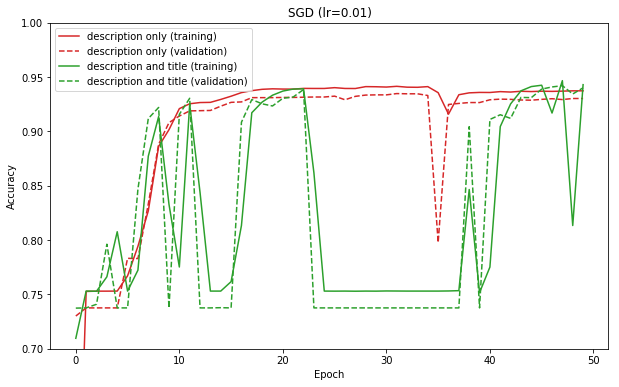

In [37]:
plt.figure(figsize=(10,6))
plt.plot(r_sgd_t.Step, r_sgd_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_sgd_v.Step, r_sgd_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_sgd_t.Step, rc_sgd_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_sgd_v.Step, rc_sgd_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('SGD (lr=0.01)')
plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./sgd.png', bbox_inches='tight')
plt.show()

Adam

In [38]:
r_t = pd.read_csv('./run_r_logs_training-tag-acc.csv')
r_v = pd.read_csv('./run_r_logs_validation-tag-acc.csv')

rc_t = pd.read_csv('./run_rc_logs_training-tag-acc.csv')
rc_v = pd.read_csv('./run_rc_logs_validation-tag-acc.csv')

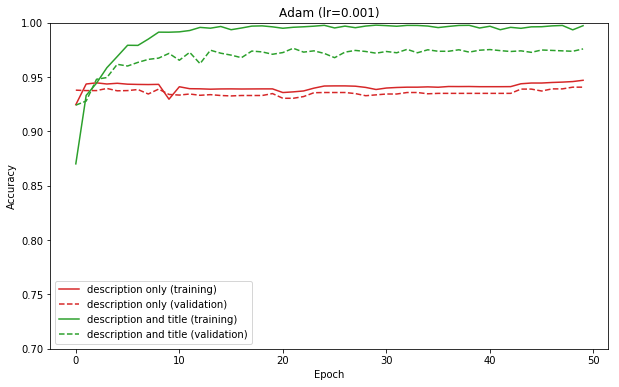

In [39]:
plt.figure(figsize=(10,6))
plt.plot(r_t.Step, r_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_v.Step, r_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_t.Step, rc_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_v.Step, rc_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Adam (lr=0.001)')
plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./adam.png', bbox_inches='tight')
plt.show()

Adam, OOV

In [40]:
r_oov_t = pd.read_csv('./run_r_oov_logs_training-tag-acc.csv')
r_oov_v = pd.read_csv('./run_r_oov_logs_validation-tag-acc.csv')

rc_oov_t = pd.read_csv('./run_rc_oov_logs_training-tag-acc.csv')
rc_oov_v = pd.read_csv('./run_rc_oov_logs_validation-tag-acc.csv')

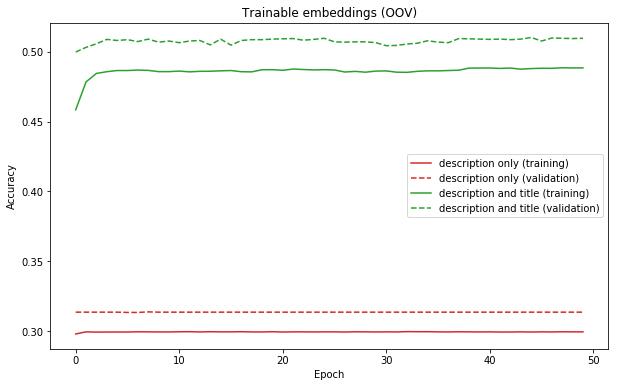

In [41]:
plt.figure(figsize=(10,6))
plt.plot(r_oov_t.Step, r_oov_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_oov_v.Step, r_oov_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_oov_t.Step, rc_oov_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_oov_v.Step, rc_oov_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Trainable embeddings (OOV)')
# plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./oov.png', bbox_inches='tight')
plt.show()

Train all embeddings

In [42]:
r_tall_t = pd.read_csv('./run_r_tall_logs_training-tag-acc.csv')
r_tall_v = pd.read_csv('./run_r_tall_logs_validation-tag-acc.csv')

rc_tall_t = pd.read_csv('./run_rc_tall_logs_training-tag-acc.csv')
rc_tall_v = pd.read_csv('./run_rc_tall_logs_validation-tag-acc.csv')

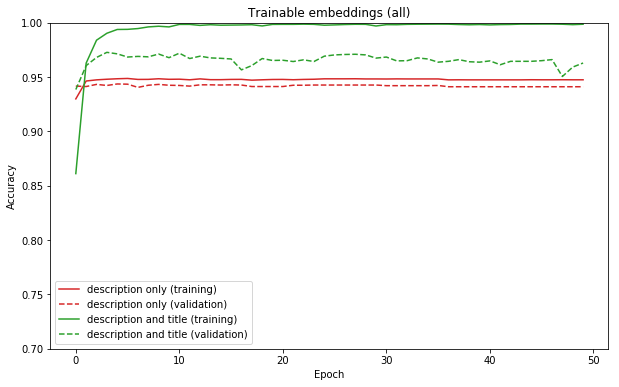

In [43]:
plt.figure(figsize=(10,6))
plt.plot(r_tall_t.Step, r_tall_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_tall_v.Step, r_tall_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_tall_t.Step, rc_tall_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_tall_v.Step, rc_tall_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Trainable embeddings (all)')
plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./tall.png', bbox_inches='tight')
plt.show()

Dropout

In [44]:
r_drop_t = pd.read_csv('./run_r_drop_logs_training-tag-acc.csv')
r_drop_v = pd.read_csv('./run_r_drop_logs_validation-tag-acc.csv')

rc_drop_t = pd.read_csv('./run_rc_drop_logs_training-tag-acc.csv')
rc_drop_v = pd.read_csv('./run_rc_drop_logs_validation-tag-acc.csv')

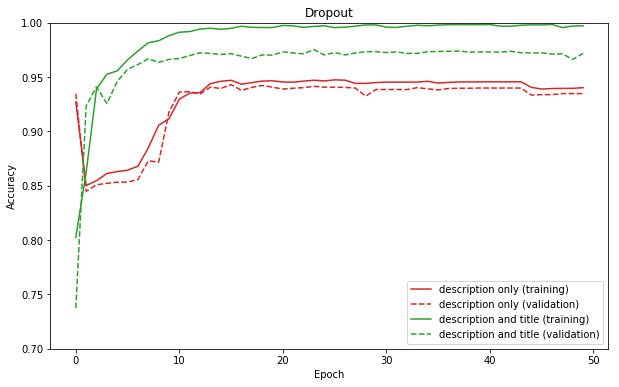

In [45]:
plt.figure(figsize=(10,6))
plt.plot(r_drop_t.Step, r_drop_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_drop_v.Step, r_drop_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_drop_t.Step, rc_drop_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_drop_v.Step, rc_drop_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Dropout')
plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./drop.png', bbox_inches='tight')
plt.show()

Train all embeddings + dropout

In [46]:
r_tall_drop_t = pd.read_csv('./run_r_tall_drop_logs_training-tag-acc.csv')
r_tall_drop_v = pd.read_csv('./run_r_tall_drop_logs_validation-tag-acc.csv')

rc_tall_drop_t = pd.read_csv('./run_rc_tall_drop_logs_training-tag-acc.csv')
rc_tall_drop_v = pd.read_csv('./run_rc_tall_drop_logs_validation-tag-acc.csv')

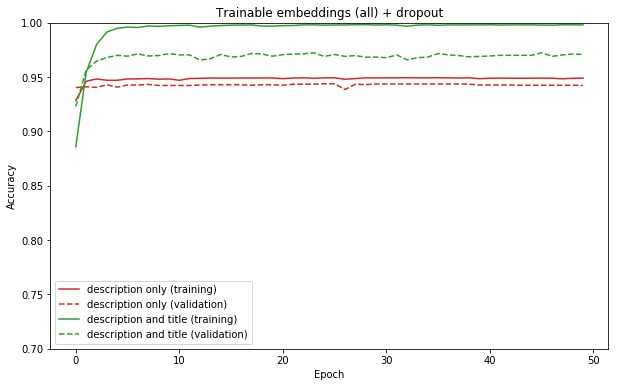

In [47]:
plt.figure(figsize=(10,6))
plt.plot(r_tall_drop_t.Step, r_tall_drop_t.Value, c='tab:red', ls='-', label='description only (training)')
plt.plot(r_tall_drop_v.Step, r_tall_drop_v.Value, c='tab:red', ls='--', label='description only (validation)')
plt.plot(rc_tall_drop_t.Step, rc_tall_drop_t.Value, c='tab:green', ls='-', label='description and title (training)')
plt.plot(rc_tall_drop_v.Step, rc_tall_drop_v.Value, c='tab:green', ls='--', label='description and title (validation)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Trainable embeddings (all) + dropout')
plt.ylim(0.7, 1.0)
plt.legend()
plt.savefig('./tall_drop.png', bbox_inches='tight')
plt.show()

review+claim validation loss comparison (find best model):

In [48]:
rc_drop = pd.read_csv('./val_loss/run_rc_drop_logs_validation-tag-loss.csv')
rc = pd.read_csv('./val_loss/run_rc_logs_validation-tag-loss.csv')
rc_oov = pd.read_csv('./val_loss/run_rc_oov_logs_validation-tag-loss.csv')
rc_sgd = pd.read_csv('./val_loss/run_rc_sgd_logs_validation-tag-loss.csv')
rc_tall_drop = pd.read_csv('./val_loss/run_rc_tall_drop_logs_validation-tag-loss.csv')
rc_tall = pd.read_csv('./val_loss/run_rc_tall_logs_validation-tag-loss.csv')

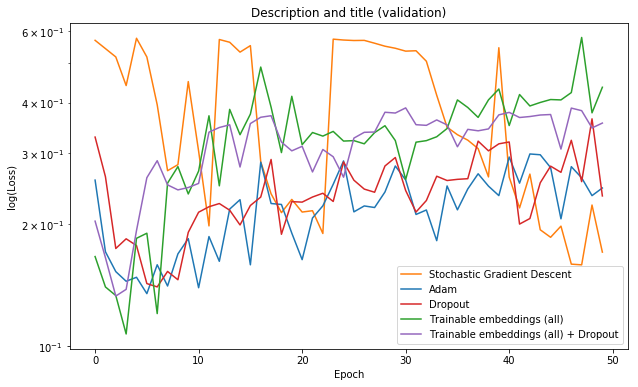

In [49]:
plt.figure(figsize=(10,6))
plt.plot(rc_sgd.Step, rc_sgd.Value, c='tab:orange', ls='-', label='Stochastic Gradient Descent')
plt.plot(rc.Step, rc.Value, c='tab:blue', ls='-', label='Adam')
plt.plot(rc_drop.Step, rc_drop.Value, c='tab:red', ls='-', label='Dropout')
# plt.plot(rc_oov.Step, rc_oov.Value, c='tab:brown', ls='-', label='Trainable embeddings (OOV)')
plt.plot(rc_tall.Step, rc_tall.Value, c='tab:green', ls='-', label='Trainable embeddings (all)')
plt.plot(rc_tall_drop.Step, rc_tall_drop.Value, c='tab:purple', ls='-', label='Trainable embeddings (all) + Dropout')
plt.ylabel('log(Loss)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.title('Description and title (validation)')
plt.legend()
# plt.savefig('./val_loss.png', bbox_inches='tight')
plt.show()

---